In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation

from os import listdir
from os.path import isfile, join
import sys, os, re

from sklearn.metrics import r2_score
from scipy.stats import gamma, beta
import talib
from tqdm.notebook import tqdm
from functools import partial
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

np.set_printoptions(suppress=True)

In [2]:
sys.path.append("../src")
from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior, length_scale_prior
from micro_models import dynamic_batch_diffusion, fast_dm_simulate, diffusion_trial
from networks import DynamicGaussianNetworkJoint
from context import generate_design_matrix
from transformations import unscale_z, scale_z

In [3]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [4]:
T          = 3200
N_PARAMS   = 6
DIST_MAT   = build_distance_matrix(T)
AMPLITUDES = [0.1, 0.1, 0.1, 0.1, 0.05, 0.05]

N_SAMPLES  = 500
N_SIM      = 100
BATCH_SIZE = 16
TEST_SIZE  = 10
N_CHUNKS   = 8000
EPOCHS     = 50

In [5]:
MACRO_MEAN = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
MACRO_STD  = [2.8, 2.8, 2.8, 2.8, 2.8, 2.8]
MICRO_MEAN = [1.3, 1.3, 1.3, 1.3, 1.3, 0.3]
MICRO_STD  = [1.0, 1.0, 1.0, 1.0, 0.75, 0.25]

In [6]:
EMPIRIC_COLOR    = '#1F1F1F'
NEURAL_COLOR     = '#852626'
COMPARISON_COLOR = '#133a76'

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [7]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [8]:
def generator_fun(batch_size):
    repeat = True
    while repeat:
        theta0 = diffusion_prior(batch_size, n_cond=N_PARAMS-2)
        eta = length_scale_prior(batch_size, N_PARAMS)
        theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
        if min(theta_t[:, :, 4].flatten()) > 0.059:
            repeat = False
            
    context = generate_design_matrix(batch_size, T)

    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    eta_z = scale_z(eta, MACRO_MEAN, MACRO_STD)
    theta_t_z = scale_z(theta_t, MICRO_MEAN, MICRO_STD)

    return eta_z.astype(np.float32), theta_t_z.astype(np.float32), x.astype(np.float32)

In [9]:
def presimulate_data():
    for n in range(N_CHUNKS):
        eta_z, theta_t_z, x = generator_fun(BATCH_SIZE)
        np.save(f'../data/offline_data_new_2/data/x_{n}.npy', x)
        np.save(f'../data/offline_data_new_2/parameters/eta/eta_params_{n}.npy', eta_z)
        np.save(f'../data/offline_data_new_2/parameters/theta/theta_params_{n}.npy', theta_t_z)

In [10]:
# presimulate_data()

In [11]:
class ChunkLoader:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.data_list = sorted(os.listdir(os.path.join(path_to_data, 'data')), key=lambda f: int(re.sub('\D', '', f)))
        self.eta_list = sorted(os.listdir(os.path.join(path_to_data, 'parameters/eta')), key=lambda f: int(re.sub('\D', '', f)))
        self.theta_list = sorted(os.listdir(os.path.join(path_to_data, 'parameters/theta')), key=lambda f: int(re.sub('\D', '', f)))
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.num_batches = len(self.data_list)
        self.current_index = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_index < self.num_batches:
            self.current_index += 1
            idx = self.indices[self.current_index -1]
            batch_x = np.load(os.path.join(self.path_to_data, 'data', self.data_list[idx]))
            batch_eta_params = np.load(os.path.join(self.path_to_data, 'parameters/eta', self.eta_list[idx]))
            batch_theta_params = np.load(os.path.join(self.path_to_data, 'parameters/theta', self.theta_list[idx]))
            return batch_eta_params, batch_theta_params, batch_x
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.current_index = 0
        raise StopIteration

In [12]:
# loader = ChunkLoader('../data/offline_data_new_2')

## Network

In [13]:
network_settings = {
    'embedding_lstm_units' : 512, 
    'embedding_gru_units': 512,
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkJoint(network_settings)

In [14]:
steps_per_epoch = 8000
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001,
    decay_steps=steps_per_epoch*EPOCHS)

optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [15]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [16]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step, batch in enumerate(generator):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            eta_z, theta_t_z, data = batch

            idx = np.random.choice(np.arange(0, 16), size=8, replace=False, p=None)

            # Forward pass
            posterior = network(data[idx])

            # loss computation
            loss = nll(tf.concat([tf.stack([eta_z[idx]] * T, axis=1), theta_t_z[idx]], axis=-1), posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [17]:
# losses = []
# for ep in range(1, EPOCHS+1):
#     with tqdm(total=loader.num_batches, desc=f'Training Epoch {ep}') as p_bar:
#         loss_ep = epoch_trainer(loader, network, optimizer, steps_per_epoch, p_bar)
#         losses.append(loss_ep)
#     network.save_weights('../trained_networks/full_gp_ddm_joint')

##  Fit on empirical data

In [18]:
network.load_weights('../trained_networks/full_gp_ddm_joint')

In [19]:
# read data
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0)

# prepare data for fitting
ids = np.unique(data.id)
N_SUBS = len(ids)

# negative rts for error responses
data.rt.loc[data.acc == 0] = -data.rt.loc[data.acc == 0]

# iterate over subjects
x_nn = np.zeros((len(ids), T, 5))

for id in ids:
    person_data = data[data.id == id]
    rt = np.array([person_data.rt])[:, :, np.newaxis]
    stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
    context = to_categorical(stim_type)
    x_nn[id-1] = tf.concat((rt, context), axis=-1)

x_nn.shape

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_90770/1881367097.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rt.loc[data.acc == 0] = -data.rt.loc[data.acc == 0]


(11, 3200, 5)

In [20]:
# amortized inference
post_eta_z = np.zeros((N_SAMPLES, N_SUBS, T, N_PARAMS))
post_theta_t_z = np.zeros((N_SAMPLES, N_SUBS, T, N_PARAMS))
for i in range(len(ids)):
    post_eta_z[:, i:i+1, :], post_theta_t_z[:, i:i+1, :, :] = network.sample_n(x_nn[i:i+1], N_SAMPLES)
    print("Sub nr. {} is fitted".format(i+1))

Sub nr. 1 is fitted
Sub nr. 2 is fitted
Sub nr. 3 is fitted
Sub nr. 4 is fitted
Sub nr. 5 is fitted
Sub nr. 6 is fitted
Sub nr. 7 is fitted
Sub nr. 8 is fitted
Sub nr. 9 is fitted
Sub nr. 10 is fitted
Sub nr. 11 is fitted


In [21]:
post_eta = unscale_z(post_eta_z, MACRO_MEAN, MACRO_STD)
post_theta_t = unscale_z(post_theta_t_z, MICRO_MEAN, MICRO_STD)

In [22]:
# read fast-dm parameter estimates
fast_dm_params = pd.read_csv('../data/parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params = fast_dm_params.to_numpy()[:, 1:]
fast_dm_params.shape

(11, 8)

In [23]:
# predict data with fast_dm for all subjects
pred_rt_fast_dm = np.zeros((N_SUBS, T))
for i in range(N_SUBS):
    context = data.stim_type.loc[data.id == i+1].to_numpy() - 1
    pred_rt_fast_dm[i] = fast_dm_simulate(fast_dm_params[i], context)
    
pred_rt_fast_dm.shape

(11, 3200)

In [26]:
def pr_check(emp_data, post_theta_t, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/n_sim, dtype=np.int32)
    theta = post_theta_t[idx]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta[sim, t, context[t]], theta[sim, t, 4], theta[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt, emp_rt, sma_emp_rt

In [25]:
# predict data with neural for all subjects
pred_rt_neural = np.zeros((N_SUBS, N_SIM, T))
sma_pred_rt_neural = np.zeros((N_SUBS, N_SIM, T))

pred_rt_quantiles = np.zeros((N_SUBS, 2, T))
pred_rt_medians = np.zeros((N_SUBS, T))

emp_rt =  np.zeros((N_SUBS, T))
sma_emp_rt =  np.zeros((N_SUBS, T))

for sub in range(N_SUBS):
    # predict RTs
    person_data = data[data.id == sub+1]
    pred_rt_neural[sub], sma_pred_rt_neural[sub], emp_rt[sub], sma_emp_rt[sub] = pr_check(person_data, post_theta_t[:, sub, :, :], N_SIM)
    # compute RT quantiles
    pred_rt_quantiles[sub] = np.quantile(sma_pred_rt_neural[sub], [0.025, 0.975], axis=0)
    pred_rt_medians[sub] = np.median(sma_pred_rt_neural[sub], axis=0)
    print("Sub nr. {} is predicted".format(sub+1))

Sub nr. 1 is predicted
Sub nr. 2 is predicted
Sub nr. 3 is predicted
Sub nr. 4 is predicted
Sub nr. 5 is predicted
Sub nr. 6 is predicted
Sub nr. 7 is predicted
Sub nr. 8 is predicted
Sub nr. 9 is predicted
Sub nr. 10 is predicted
Sub nr. 11 is predicted


In [27]:
horizon=700
emp_data_horizon = x_nn[:, :T-horizon, :]

# inference on restircted data
post_eta_z_horizon = np.zeros((N_SAMPLES, N_SUBS, T-horizon, N_PARAMS))
post_theta_t_z_horizon = np.zeros((N_SAMPLES, N_SUBS, T-horizon, N_PARAMS))
for i in range(len(ids)):
    post_eta_z_horizon[:, i:i+1, :, :], post_theta_t_z_horizon[:, i:i+1, :, :] = network.sample_n(emp_data_horizon[i:i+1], N_SAMPLES)
    print("Sub nr. {} is fitted".format(i+1))

Sub nr. 1 is fitted
Sub nr. 2 is fitted
Sub nr. 3 is fitted
Sub nr. 4 is fitted
Sub nr. 5 is fitted
Sub nr. 6 is fitted
Sub nr. 7 is fitted
Sub nr. 8 is fitted
Sub nr. 9 is fitted
Sub nr. 10 is fitted
Sub nr. 11 is fitted


In [28]:
post_eta_last = unscale_z(post_eta_z_horizon[:, :, -1, :], MACRO_MEAN, MACRO_STD)
post_theta_last = unscale_z(post_theta_t_z_horizon[:, :, -1, :], MICRO_MEAN,  MICRO_STD)

In [29]:
idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/N_SIM, dtype=np.int32)
post_eta_last_select = post_eta_last[idx]
post_theta_last_select = post_theta_last[idx]
post_eta_last_select.shape

(100, 11, 6)

In [30]:
# generate dynamic parameters and simulate RTs
pred_rt_horizon = np.zeros((N_SIM, N_SUBS, horizon, 1))
sma_pred_rt_horizon = np.zeros((N_SIM, N_SUBS, horizon, 1))

context = x_nn[:, :, 1:].argmax(axis=2)[:, T-horizon:]
dist_mat_horizon = build_distance_matrix(horizon)
for sub in range(N_SUBS):
    for i in range(N_SIM):
        pred_theta_t = batched_gaussian_process(post_theta_last_select[i, sub:sub+1], dist_mat_horizon, post_eta_last_select[i, sub:sub+1], amplitudes=AMPLITUDES)
        pred_rt_horizon[i, sub:sub+1] = np.abs(dynamic_batch_diffusion(pred_theta_t, context[sub:sub+1]).astype(np.float32))
        sma_pred_rt_horizon[i, sub, :, 0] = talib.SMA(pred_rt_horizon[i, sub, :, 0], timeperiod=5)

    print("Sub nr. {} is predicted".format(sub+1))

Sub nr. 1 is predicted
Sub nr. 2 is predicted
Sub nr. 3 is predicted
Sub nr. 4 is predicted
Sub nr. 5 is predicted
Sub nr. 6 is predicted
Sub nr. 7 is predicted
Sub nr. 8 is predicted
Sub nr. 9 is predicted
Sub nr. 10 is predicted
Sub nr. 11 is predicted


In [31]:
pred_rt_horizon_medians = np.median(sma_pred_rt_horizon, axis=0)
pred_rt_horizon_quantiles = np.quantile(sma_pred_rt_horizon, [0.025, 0.975], axis=0)

In [32]:
def reorderLegend2(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

In [33]:
FONT_SIZE_1 = 24
FONT_SIZE_2 = 22
FONT_SIZE_3 = 18

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

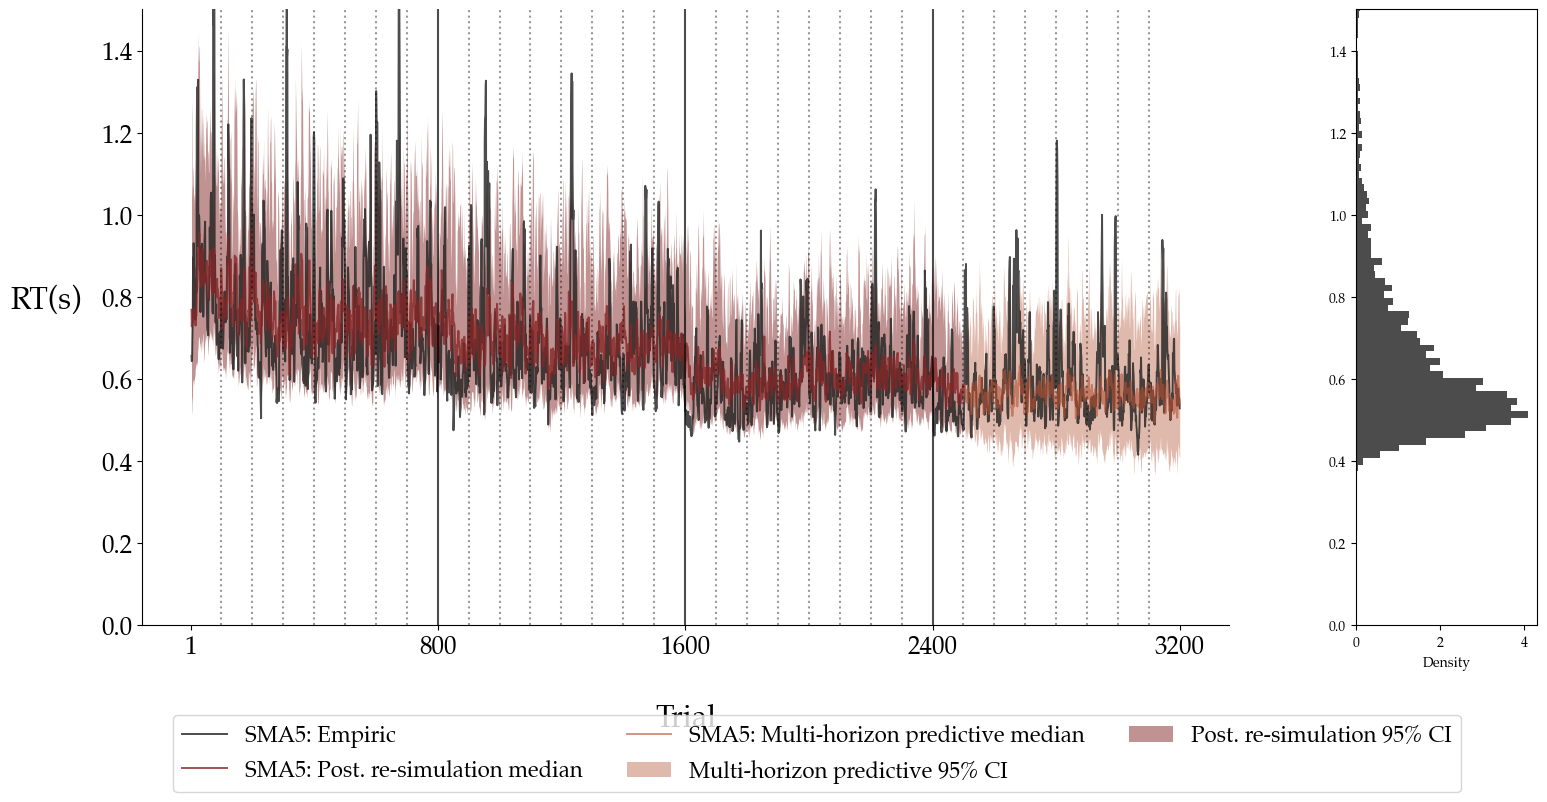

In [34]:
# initialize figure
horizon = 700
for sub in range(N_SUBS):
    f, ax = plt.subplots(1, 2, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [6, 1]})
    axrr = ax.flat
    # plot empiric and predicted response times series
    time = np.arange(T) 

    axrr[0].plot(time, sma_emp_rt[sub], color=EMPIRIC_COLOR, lw=1.4, alpha=0.8, label='SMA5: Empiric')
    axrr[0].plot(time[:T-horizon], pred_rt_medians[sub, :T-horizon], color=NEURAL_COLOR, lw=1.4, label='SMA5: Post. re-simulation median', alpha=0.8)
    axrr[0].plot(time[T-horizon:], pred_rt_horizon_medians[sub], color="#b35032", lw=1.4, label='SMA5: Multi-horizon predictive median', alpha=0.6)
    axrr[0].fill_between(time[T-horizon:], pred_rt_horizon_quantiles[0, sub, :, 0], pred_rt_horizon_quantiles[1, sub, :, 0], color="#b35032", linewidth=0, alpha=0.4, label='Multi-horizon predictive 95% CI')
    axrr[0].fill_between(time[:T-horizon], pred_rt_quantiles[sub, 0, :T-horizon], pred_rt_quantiles[sub, 1, :T-horizon], color=NEURAL_COLOR, linewidth=0, alpha=0.5, label='Post. re-simulation 95% CI')
    
    for idx in np.argwhere(person_data.session.diff().values == 1):
        if idx == 800:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
        else:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    for idx in np.argwhere(person_data.block.diff().values == 1):
        if idx == 100:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    sns.despine(ax=axrr[0])
    axrr[0].set_ylabel('RT(s)', fontsize=FONT_SIZE_2, rotation=0, labelpad=40)
    axrr[0].set_xlabel('\nTrial', fontsize=FONT_SIZE_2)
    axrr[0].tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)

    f.legend(fontsize=16, loc='center', 
            bbox_to_anchor=(0.5, -0.05), ncol=3)

    axrr[0].grid(False)
    axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

    # plot empiric and predicted response time dist
    plt.setp(ax, ylim=(0, 1.5))
    sns.histplot(y=np.abs(emp_rt[sub]), fill=EMPIRIC_COLOR, color=EMPIRIC_COLOR, alpha=0.8, label="Empiric", ax=axrr[1], stat="density", bins=250, linewidth=0)#062759
    sns.kdeplot(y=np.abs(pred_rt_fast_dm[sub]), fill= COMPARISON_COLOR, color='#3fa0ba', alpha=0.3, label="Fast-dm", ax=axrr[1], linewidth=3.5)#598f70
    sns.kdeplot(y=pred_rt_neural[sub].flatten(), fill=NEURAL_COLOR, color=NEURAL_COLOR, alpha=0.3, label="Dynamic DDM", ax=axrr[1], linewidth=3.5)

    axrr[1].legend(fontsize=FONT_SIZE_3)
    axrr[1].set_xlabel('', fontsize=FONT_SIZE_2)
    axrr[1].tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    axrr[1].set_yticklabels('')
    axrr[1].set_xticklabels('')
    axrr[1].xaxis.set_ticks([])
    axrr[1].yaxis.set_ticks([])
    axrr[1].get_xaxis().set_visible(False)
    for line in axrr[1].get_lines():
        line.set_alpha(1)
    sns.despine(ax=axrr[1], bottom=True)

    axrr[0].annotate('Re-simulation',
                xy=(0.38, 1), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=FONT_SIZE_2, ha='center', va='top', weight="bold")

    axrr[0].annotate('Prediction',
                xy=(0.84, 1), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=FONT_SIZE_2, ha='center', va='top', weight="bold")

    axrr[0].tick_params(length=8)

    plt.subplots_adjust(wspace = 0.05)
    f.tight_layout()
    f.savefig("../plots/gpddm_rt_time_series_sub_{}.pdf".format(sub+1), dpi=300, bbox_inches='tight')

In [ ]:
def plot_dynamic_posteriors(dynamic_posterior, fast_dm_params, par_labels, par_names, 
                            ground_truths=None):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
        
    means = dynamic_posterior.mean(axis=0)
    stds = dynamic_posterior.std(axis=0)
    
    post_max = np.array(means).max(axis=0)
    post_min = np.array(means).min(axis=0)
    upper_y_ax = post_max + [1, 1, 1, 1, 0.2, 0.05]
    lower_y_ax = post_min - [1, 1, 1, 1, 0.2, 0.05]

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        ci_upper = means[:, i] + stds[:, i]
        ci_lower = means[:, i] - stds[:, i]
        ax.plot(time, means[:, i], color=NEURAL_COLOR, label='Post. mean')
        ax.fill_between(time, ci_upper, ci_lower, color=NEURAL_COLOR, alpha=0.6, linewidth=0, label='Post. std. deviation')

        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)

        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel("Parameter value", fontsize=18)

        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.set_ylim(lower_y_ax[i], upper_y_ax[i])

        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)


        # horizontal fast-dm params
        if i <= 3:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Fast-dm estimate', lw=2.5)
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[6], fast_dm_params[i] + fast_dm_params[6], color=COMPARISON_COLOR, alpha=0.3, linewidth=0, label='Fast-dm inter-trial variability')
        elif i == 4:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Fast-dm estimate', lw=2.5)
        else:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Fast-dm estimate', lw=2.5)
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[7]/2, fast_dm_params[i] + fast_dm_params[7]/2, color=COMPARISON_COLOR, alpha=0.3, linewidth=0, label='Fast-dm inter-trial variability')


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()
    f.savefig("../plots/gpddm_param_dynamic_sub_{}.pdf".format(sub+1), dpi=300, bbox_inches="tight")

In [ ]:
for sub in range(N_SUBS):
    plot_dynamic_posteriors(post_theta_t[:, sub, :, :], fast_dm_params[sub], PARAM_LABELS, PARAM_NAMES)
    print("Sub {} is finished".format(sub+1))

## Evaluation: Average Parameter Dynamic

In [ ]:
# compute means and stds for neural and fast-dm parameters
neural_means = post_theta_t.mean(axis=0).mean(axis=0)
neural_stds = post_theta_t.mean(axis=0).std(axis=0)

fast_dm_means = fast_dm_params.mean(axis=0)
fast_dm_sd = fast_dm_params.std(axis=0)

post_max = np.array(neural_means).max(axis=0).max()
upper_y_ax = post_max + 1

sigma_factors = [1]
alphas = [0.6]

time = np.arange(T)
f, axarr = plt.subplots(2, 3, figsize=(18, 8))
for i, ax in enumerate(axarr.flat):
    ax.plot(time, neural_means[:, i], color=NEURAL_COLOR, label='Average post. mean')
    for sigma_factor, alpha in zip(sigma_factors, alphas):
        ci_upper = neural_means[:, i] + sigma_factor * neural_stds[:, i]
        ci_lower = neural_means[:, i] - sigma_factor * neural_stds[:, i]
        ax.fill_between(time, ci_upper, ci_lower, color=NEURAL_COLOR, alpha=alpha, linewidth=0, label='Std. deviation post. mean')
    sns.despine(ax=ax)

    if i == 0:
        ax.set_xlabel('Trial', fontsize=18)
        ax.set_ylabel("Parameter value", fontsize=18)

    ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)
    ax.set_xticks([1, 800, 1600, 2400, 3200])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(False)

    # vertical bars
    for idx in np.arange(799, 2400, 800):
        if idx == 799:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
        else:
            ax.axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.5)
    for idx in np.arange(99, 3100, 100):
        if idx == 99:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            ax.axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)

    # horizontal fast-dm params
    ax.plot(time, np.repeat(fast_dm_means[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Average Fast-dm estimate', lw=2.5)
    ax.fill_between(time, fast_dm_means[i] - fast_dm_sd[i], fast_dm_means[i] + fast_dm_sd[i], color=COMPARISON_COLOR, alpha=0.3, linewidth=0, label='Std. deviation Fast-dm estimate')

    f.subplots_adjust(hspace=0.5)
    if i == 0:
        f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05),fancybox=False, shadow=False, ncol=4)

f.tight_layout()
f.savefig("../plots/gpddm_average_param_dynamic.pdf", dpi=300, bbox_inches="tight")

## Parameter recovery

In [ ]:
def pr_check_simulation(emp_data, post_theta_t, n_sim, sma_period=5):
    # get experimental context
    context = emp_data[:, 1:].argmax(axis=1)
    # get empirical response times
    emp_rt = np.abs(emp_data[:, 0], dtype=np.float64)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/n_sim, dtype=np.int32)
    theta = post_theta_t[idx]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta[sim, t, context[t]], theta[sim, t, 4], theta[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt, emp_rt, sma_emp_rt

In [ ]:
batch_size = 10
true_eta_z, true_theta_t_z, true_data = generator_fun(batch_size)
true_theta_t_z.shape

In [ ]:
# amortized inference
post_eta_z = np.zeros((N_SAMPLES, batch_size, T, N_PARAMS))
post_theta_t_z = np.zeros((N_SAMPLES, batch_size, T, N_PARAMS))
for i in range(batch_size):
    post_eta_z[:, i:i+1, :, :], post_theta_t_z[:, i:i+1, :, :] = network.sample_n(true_data[i:i+1], N_SAMPLES)
    print("Sim nr. {} is fitted".format(i+1))

In [ ]:
post_eta = unscale_z(post_eta_z, MACRO_MEAN, MACRO_STD)
post_theta_t = unscale_z(post_theta_t_z, MICRO_MEAN, MICRO_STD) 

true_eta = unscale_z(true_eta_z, MACRO_MEAN, MACRO_STD)
true_theta_t = unscale_z(true_theta_t_z, MICRO_MEAN, MICRO_STD)

In [ ]:
# predict data with neural for all subjects
pred_rt_neural = np.zeros((batch_size, N_SIM, T))
sma_pred_rt_neural = np.zeros((batch_size, N_SIM, T))

pred_rt_quantiles = np.zeros((batch_size, 2, T))
pred_rt_medians = np.zeros((batch_size, T))

true_rt =  np.zeros((batch_size, T))
sma_true_rt =  np.zeros((batch_size, T))

for sim in range(batch_size):
    # predict RTs
    single_data = true_data[sim]
    pred_rt_neural[sim], sma_pred_rt_neural[sim], true_rt[sim], sma_true_rt[sim] = pr_check_simulation(single_data, post_theta_t[:, sim, :, :], N_SIM)
    # compute RT quantiles
    pred_rt_quantiles[sim] = np.quantile(sma_pred_rt_neural[sim], [0.025, 0.975], axis=0)
    pred_rt_medians[sim] = np.median(sma_pred_rt_neural[sim], axis=0)
    print("Sim nr. {} is predicted".format(sim+1))

In [ ]:
horizon=700
true_data_horizon = true_data[:, :T-horizon, :]

# inference on restircted data
post_eta_z_horizon = np.zeros((N_SAMPLES, batch_size, T-horizon, N_PARAMS))
post_theta_t_z_horizon = np.zeros((N_SAMPLES, batch_size, T-horizon, N_PARAMS))
for i in range(batch_size):
    post_eta_z_horizon[:, i:i+1, :, :], post_theta_t_z_horizon[:, i:i+1, :, :] = network.sample_n(true_data_horizon[i:i+1], N_SAMPLES)
    print("Sim nr. {} is fitted".format(i+1))

In [ ]:
post_eta_last = unscale_z(post_eta_z_horizon[:, :, -1, :], MACRO_MEAN, MACRO_STD)
post_theta_last = unscale_z(post_theta_t_z_horizon[:, :, -1, :], MICRO_MEAN, MICRO_STD)

In [ ]:
idx = np.arange(0, N_SAMPLES-1, N_SAMPLES/N_SIM, dtype=np.int32)
post_eta_last_select = post_eta_last[idx]
post_theta_last_select = post_theta_last[idx]
post_eta_last_select.shape

In [ ]:
# generate dynamic parameters and simulate RTs
pred_rt_horizon = np.zeros((N_SIM, batch_size, horizon, 1))
sma_pred_rt_horizon = np.zeros((N_SIM, batch_size, horizon, 1))

context = true_data[:, :, 1:].argmax(axis=2)[:, T-horizon:]
dist_mat_horizon = build_distance_matrix(horizon)
for sub in range(batch_size):
    for i in range(N_SIM):
        pred_theta_t = batched_gaussian_process(post_theta_last_select[i, sub:sub+1], dist_mat_horizon, post_eta_last_select[i, sub:sub+1], amplitudes=AMPLITUDES)
        pred_rt_horizon[i, sub:sub+1] = np.abs(dynamic_batch_diffusion(pred_theta_t, context[sub:sub+1]).astype(np.float32))
        sma_pred_rt_horizon[i, sub, :, 0] = talib.SMA(pred_rt_horizon[i, sub, :, 0], timeperiod=5)

    print("Sub nr. {} is predicted".format(sub+1))

In [ ]:
pred_rt_horizon_medians = np.median(sma_pred_rt_horizon, axis=0)
pred_rt_horizon_quantiles = np.quantile(sma_pred_rt_horizon, [0.025, 0.975], axis=0)

In [ ]:
# initialize figure
horizon = 700
for sub in range(batch_size):
    f, ax = plt.subplots(1, 2, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [6, 1]})
    axrr = ax.flat
    # plot empiric and predicted response times series
    time = np.arange(T)
    N_OBS = T

    axrr[0].plot(time, sma_true_rt[sub], color=EMPIRIC_COLOR, lw=1.4, alpha=0.7, label='SMA5: Simulated')
    axrr[0].plot(time[:N_OBS-horizon], pred_rt_medians[sub, :N_OBS-horizon], color=NEURAL_COLOR, lw=1.4, label='SMA5: Post. re-simulation median', alpha=0.8)
    axrr[0].plot(time[N_OBS-horizon:], pred_rt_horizon_medians[sub], color="#b35032", lw=1.4, label='SMA5: Multi-horizon predictive median', alpha=0.6)
    axrr[0].fill_between(time[N_OBS-horizon:], pred_rt_horizon_quantiles[0, sub, :, 0], pred_rt_horizon_quantiles[1, sub, :, 0], color="#b35032", linewidth=0, alpha=0.4, label='Multi-horizon predictive 95% CI')
    axrr[0].fill_between(time[:N_OBS-horizon], pred_rt_quantiles[sub, 0, :N_OBS-horizon], pred_rt_quantiles[sub, 1, :N_OBS-horizon], color=NEURAL_COLOR, linewidth=0, alpha=0.5, label='Post. re-simulation 95% CI')
    sns.despine(ax=axrr[0])
    axrr[0].set_ylabel('RT(s)', fontsize=18, rotation=0, labelpad=40)
    axrr[0].set_xlabel('\nTrial', fontsize=18)
    axrr[0].tick_params(axis='both', which='major', labelsize=16)

    f.legend(fontsize=16, loc='center', 
            bbox_to_anchor=(0.5, -0.05), ncol=3)

    
    axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

    # plot empiric and predicted response time dist
    plt.setp(ax, ylim=(0, np.nanmax(pred_rt_medians[sub])*1.5))
    sns.histplot(y=np.abs(true_rt[sub]), fill=EMPIRIC_COLOR, color=EMPIRIC_COLOR, alpha=0.7, label="Simulated", ax=axrr[1], stat="density", bins=250, linewidth=0)
    sns.kdeplot(y=pred_rt_neural[sub].flatten(), fill=NEURAL_COLOR, color=NEURAL_COLOR, alpha=0.3, label="Dynamic DDM", ax=axrr[1], linewidth=3.5)

    axrr[1].legend(fontsize=16)
    axrr[1].set_xlabel('', fontsize=18)
    axrr[1].tick_params(axis='both', which='major', labelsize=16)
    axrr[1].set_yticklabels('')
    axrr[1].set_xticklabels('')
    axrr[1].xaxis.set_ticks([])
    axrr[1].yaxis.set_ticks([])
    axrr[1].get_xaxis().set_visible(False)
    for line in axrr[1].get_lines():
        line.set_alpha(1)
    sns.despine(ax=axrr[1], bottom=True)

    axrr[0].annotate('Re-simulation',
                xy=(0.38, 1), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].annotate('Prediction',
                xy=(0.84, 1), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].tick_params(length=8)
    axrr[0].grid(False)

    plt.subplots_adjust(wspace = 0.05)
    f.tight_layout()
    f.savefig("../plots/rt_time_series_simulation_{}.pdf".format(sub+1), dpi=300, bbox_inches='tight')

In [ ]:
def plot_dynamic_posteriors_simulation(dynamic_posterior, ground_truths, par_labels, par_names):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
        
    means = dynamic_posterior.mean(axis=0)
    std = dynamic_posterior.std(axis=0)
    
    post_max = np.array(means).max(axis=0)
    post_min = np.array(means).min(axis=0)
    upper_y_ax = post_max + [1, 1, 1, 1, 0.2, 0.05]
    lower_y_ax = post_min - [1, 1, 1, 1, 0.2, 0.05]

    sigma_factors = [1]
    alphas = [0.5]

    time = np.arange(dynamic_posterior.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=NEURAL_COLOR, label='Post. mean', lw=1.5, alpha=0.8)
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=NEURAL_COLOR, alpha=alpha, linewidth=0, label='Post. std. deviation')
            ax.plot(time, ground_truths[:, i], color=EMPIRIC_COLOR, label='True Dynamic', lw=2, alpha=0.8)

        sns.despine(ax=ax)
        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel("Parameter value", fontsize=18)


        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.set_ylim(lower_y_ax[i], upper_y_ax[i])

        ax.grid(False)


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()
    f.savefig("../plots/param_dynamic_simulation_{}.pdf".format(sim+1), dpi=300, bbox_inches="tight")

In [ ]:
for sim in range(BATCH_SIZE):
    plot_dynamic_posteriors_simulation(post_theta_t[:, sim, :, :], true_theta_t[sim], PARAM_LABELS, PARAM_NAMES)

In [ ]:
PARAM_NAMES  = [r'$\eta_{v_1}$', r'$\eta_{v_2}$', r'$\eta_{v_3}$', r'$\eta_{v_4}$', r'$\eta_{a}$', r'$\eta_{\tau}$']

for sim in range(BATCH_SIZE):
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        sns.kdeplot(post_eta[:, sim, 2999, i], ax=ax, color='#852626', fill='#852626', alpha=0.5, label="Post.", lw=2)
        ax.axvline(true_eta[sim, i], label='True', color="#062759", lw=2)

        if i == 0:
            ax.set_xlabel('Parameter value', fontsize=18)
            ax.set_ylabel("Density", fontsize=18)
        else:
            ax.set_ylabel("", fontsize=18)

        ax.set_title('Eta ' + PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=20)

        ax.tick_params(axis='both', which='major', labelsize=16)

        sns.despine(ax=ax)
        ax.grid(False)

        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                    bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()

## Parameter recovery animation

In [ ]:
n_sim = 500
n_post_samples = 250

In [ ]:
%%time
# generate data
eta_z, theta_t_z, data = generator_fun(n_sim, N_OBS)
print(eta_z.shape)
print(theta_t_z.shape)
print(data.shape)

In [ ]:
n_chunks = 100
chunk_len = int(data.shape[0] / n_chunks)
chunk_len

In [ ]:
%%time
counter = 0
theta_z_pred = np.zeros((n_post_samples, n_sim, N_OBS, N_PARAMS), dtype=np.float32)
eta_z_pred = np.zeros((n_post_samples, n_sim, N_OBS, N_PARAMS), dtype=np.float32)
for x in tf.split(data, n_chunks, axis=0):
    dists = network(x)
    post = dists.sample(n_post_samples).numpy()
    theta_z_pred[:, counter*chunk_len:(counter+1)*chunk_len] = post[:, :, :, 6:]
    eta_z_pred[:, counter*chunk_len:(counter+1)*chunk_len] = post[:, :, :, :6]
    print(counter)
    counter += 1

In [ ]:
theta_pred_means = np.mean(theta_z_pred, axis=0)
theta_pred_stds = np.std(theta_z_pred, axis=0)
eta_pred_mean = np.mean(eta_z_pred[:, :, -1, :], axis=0)
eta_pred_std = np.std(eta_z_pred[:, :, -1, :], axis=0)
theta_pred_means = unscale_z(theta_pred_means, MICRO_MEAN, MICRO_STD)
theta_pred_stds = theta_pred_stds * MICRO_STD
eta_pred_mean = unscale_z(eta_pred_mean, MACRO_MEAN, MACRO_STD)
eta_pred_std = eta_pred_std * MACRO_STD
theta_true = (theta_z_true * MICRO_STD) + MICRO_MEAN
eta_true = (eta_z_true * MACRO_MEAN) + MACRO_STD

In [ ]:
FONT_SIZE_1 = 10
FONT_SIZE_2 = 9
FONT_SIZE_3 = 7
FONT_SIZE_4 = 3

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [ ]:
f, axarr = plt.subplots(1, 6, figsize=(12, 3))
from celluloid import Camera
camera = Camera(f)
for t in np.arange(0, 3201, step=13):
    for i, ax in enumerate(axarr.flat):
        ax.grid(alpha=0.5)
        # content
        ax.scatter(theta_true[:, t, i], theta_pred_means[:, t, i], alpha=0.5, color=NEURAL_COLOR)
 
        # Make plots quadratic to avoid visual illusions
        lower = min(theta_true[:, :, i].min(), theta_pred_means[:, :, i].min())
        upper = max(theta_true[:, :, i].max(), theta_pred_means[:, :, i].max())
        eps = (upper - lower) * 0.1
        ax.set_xlim([lower - eps, upper + eps])
        ax.set_ylim([lower - eps, upper + eps])

        ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], 
                 color='black', alpha=0.9, linestyle='dashed')


        # description
        ax.set_title(PARAM_LABELS[i] + ' ({})'.format(PARAM_NAMES[i]), fontsize=FONT_SIZE_1)
        if i == 0:
            ax.set_xlabel('Ground truth', fontsize=FONT_SIZE_2)
            ax.set_ylabel('Estimated', fontsize=FONT_SIZE_2)
        if i == 2:
            ax.annotate(r'$t =${}'.format(t), xy=(1, -0.4), xycoords=('axes fraction', 'axes fraction'),
                        xytext=(0, 0), textcoords='offset points', size=FONT_SIZE_1, ha='center', va='bottom')
        r2 = r2_score(theta_true[:, t, i], theta_pred_means[:, t, i])
        ax.text(0.1, 0.8, '$R^2$ = {:.3f}'.format(r2),
                    horizontalalignment='left',
                    verticalalignment='center',
                    transform=ax.transAxes, 
                    size=FONT_SIZE_3)
        corr = np.corrcoef(theta_true[:, t, i], theta_pred_means[:, t, i])[0, 1]
        ax.text(0.1, 0.7, '$r$ = {:.3f}'.format(corr),
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=ax.transAxes, 
                        size=FONT_SIZE_3)

        # aesthetics
        ax.axis('square')
        
        sns.despine(ax=ax)
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_4)

    plt.pause(0.00001)
    camera.snap()

animation = camera.animate()
animation.save('../plots/param_recovery_animation.gif', dpi=100, writer='PillowWriter', fps=1000)